# TP Méthodes haute résolution

In [3]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sounddevice as sd

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
import mdct
from scipy.io.wavfile import write
from scipy.fft import fft, ifft, rfft, irfft
from scipy.linalg import hankel
from scipy.signal import find_peaks
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

# %matplotlib widget

# Useful functions

In [4]:
def load_sound(file):
    return wave.open(file, 'rb')

def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [5]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    # outer(a,b) = a*b.T
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

## Signal synthétique

### Analyse spectrale par transformation de Fourier

In [6]:
rng = np.random.default_rng()

In [7]:
delta = np.array([0, -0.05])
a = np.array([1, 10])
N = 63
f = np.array([1/4, 1/4 + 1/N])
phi = rng.random(2)*2*np.pi

x = Synthesis(N, delta, f, a, phi)

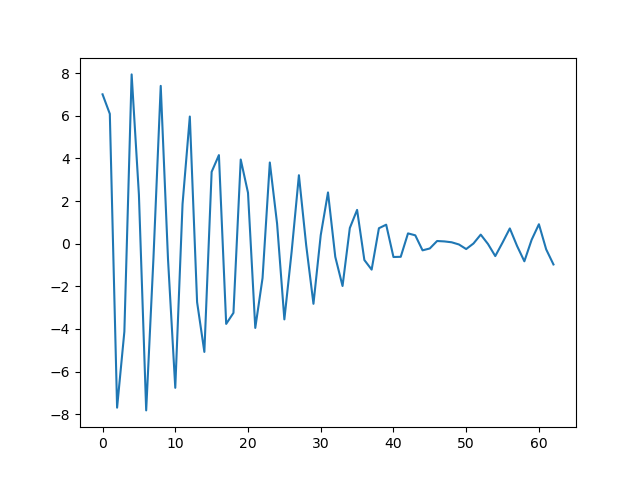

In [8]:
plt.plot(np.arange(N), np.real(x))
plt.show()

Text(0, 0.5, '$|X(f)| (dB)$')

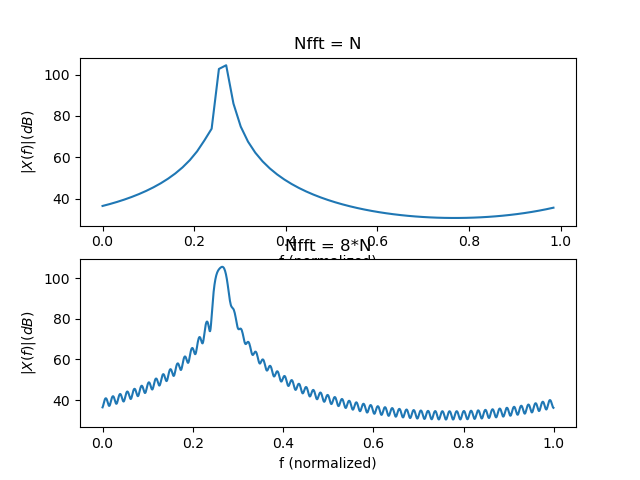

In [9]:
Nfft = N
X = fft(x, Nfft)
f = np.linspace(0, 1, Nfft, endpoint=False)


Nfft_zero_padding = 1024
X_zero_padding = fft(x, Nfft_zero_padding)
f_zero_padding = np.linspace(0, 1, Nfft_zero_padding, endpoint=False)

plt.figure()
plt.subplot(2,1,1)
plt.title('Nfft = N')
plt.plot(f, 20*np.log(np.abs(X)))
plt.xlabel('f (normalized)')
plt.ylabel('$|X(f)| (dB)$')

plt.subplot(2,1,2)
plt.title('Nfft = 8*N')
plt.plot(f_zero_padding, 20*np.log(np.abs(X_zero_padding)))
plt.xlabel('f (normalized)')
plt.ylabel('$|X(f)| (dB)$')


In [10]:
phi

array([0.75648874, 5.39094539])

Les deux raies sont mieux séparables lorsque l'on effectue un zero-padding.

Selon les valeurs des $\phi_k$, les deux raies sont parfois indistinguables sur le périodogramme sans zero-padding, en particulier quand les phases initiales des deux exponentielles complexes sont proches.

### Méthodes à haute résolution

In [11]:
def auto_corr(x, n):
    N = len(x)
    l = N + 1 - n
    X = hankel(x[:n], x[n-1:])
    R = 1/l * X@X.conj().T
    return R

La variance des estimateurs est minimale quand $n=2l$ ou $l=2n$. Mais en réalité la variance n'augmente qu'assez peu entre ces deux valeurs.

Se placer à $n=l=N/2$ garantit que la variance n'est "pas trop grande".

In [12]:
N = len(x)
n = 32
K = 2 # 2 sinusoids
Rxx = auto_corr(x, n)
[U1,Lambda,U2] = np.linalg.svd(Rxx)

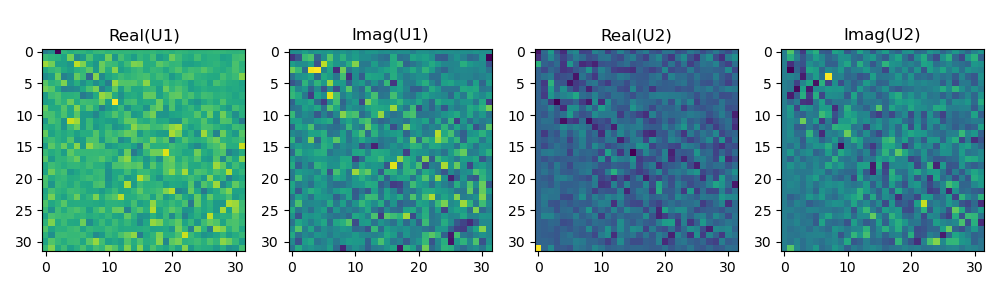

In [ ]:
fig = plt.figure(figsize=(10,3))

plt.subplot(1,4,1)
plt.imshow(np.real(U1))
plt.title("Real(U1)")
plt.subplot(1,4,2)
plt.imshow(np.imag(U1))
plt.title("Imag(U1)")

plt.subplot(1,4,3)
plt.imshow(np.real(U2))
plt.title("Real(U2)")
plt.subplot(1,4,4)
plt.imshow(np.imag(U2))
plt.title("Imag(U2)")

fig.tight_layout()
plt.show()

#### Remarque sur les vecteurs propres

On observe effectivement que les vecteurs propres de l'espace signal oscillent avec une pseudo période claire, tandis que ceux de l'espace bruit... sont du bruit.

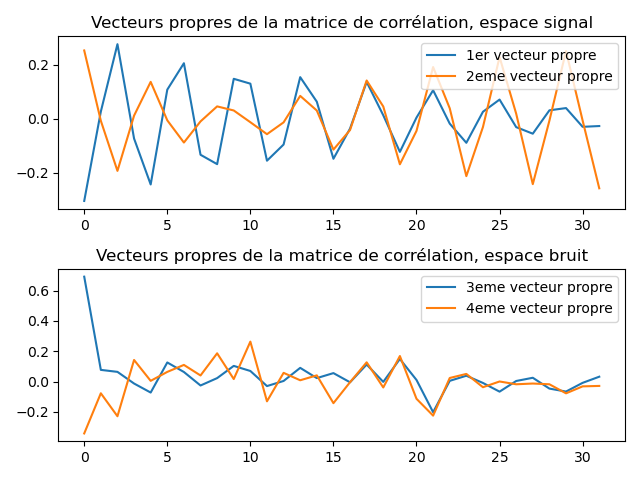

In [14]:
fig = plt.figure()
plt.subplot(2,1,1)

plt.plot(np.real(U1[:,0]), label='1er vecteur propre')
plt.plot(np.real(U1[:,1]), label='2eme vecteur propre')
plt.legend()
plt.title('Vecteurs propres de la matrice de corrélation, espace signal')

plt.subplot(2,1,2)
plt.title('Vecteurs propres de la matrice de corrélation, espace bruit')
plt.plot(np.real(U1[:,2]), label='3eme vecteur propre', alpha=1)
plt.plot(np.real(U1[:,3]), label='4eme vecteur propre', alpha=1)
plt.legend()
fig.tight_layout()

#### ESPRIT

In [16]:
def ESPRIT(x,n,K):
    Rxx = auto_corr(x, n)
    [U1,Lambda,U2] = np.linalg.svd(Rxx)
    W = U1[:,:K]
    W_down = W[:-1,:]
    W_up = W[1:,:]
    phi = np.linalg.pinv(W_down)@W_up
    z = np.linalg.eigvals(phi)
    f = np.angle(z)/(2*np.pi)
    delta = np.log(np.abs(z))
    return delta, f

delta_hat, f_hat = ESPRIT(x,n,K)

In [17]:
f_hat.shape

(2,)

In [18]:
v = delta_hat[np.newaxis, :] + 1j*2*np.pi*f_hat[np.newaxis, :]
v.shape
len(x)
# t.shape


63

In [19]:
def LeastSquares(x, delta, f):
    N = len(x)
    t = np.arange(len(x))[:, np.newaxis]
    logV = t @ (delta[np.newaxis, :] + 1j*2*np.pi*f[np.newaxis, :])
    V = np.exp(logV)
    alpha = np.linalg.pinv(V)@x
    a = np.abs(alpha)
    phi = np.angle(alpha)
    return a, phi

a_hat, phi_hat = LeastSquares(x, delta_hat, f_hat)
x_hat = Synthesis(N, delta_hat, f_hat, a_hat, phi_hat)

Text(0.5, 1.0, 'Comparaison entre $\\hat{x}_{\\mathrm{ESPRIT}}$ et $x$')

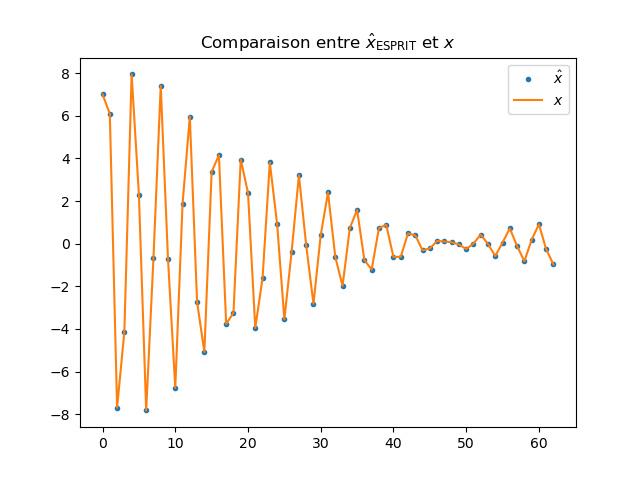

In [20]:
plt.figure()
plt.plot(np.real(x_hat), '.', label='$\hat{x}$')
plt.plot(np.real(x), label='$x$')
plt.legend()
plt.title('Comparaison entre $\hat{x}_{\mathrm{ESPRIT}}$ et $x$')

On retrouve bien le signal synthétisé.

#### MUSIC

In [50]:
def MUSIC(x, n, K):
    # Compute the covariance matrix
    Rxx = auto_corr(x, n)
    
    # Get the eigen vectors
    [U1,Lambda,U2] = np.linalg.svd(Rxx)
    W = U1[:,:K]
    W_ort = U1[:,K:]
    print("W_ort.shape=", W_ort.shape)
    
    # Span across delta and f
    delta = np.linspace(-.1, .1, 500)
    f = np.linspace(0, 1, 500)
    z = np.exp(delta[:, np.newaxis] + 1j*2*np.pi*f[np.newaxis, :])
    
    vn_z = np.stack([z**i for i in range(n)], axis=1)
    W_ort_2 = W_ort.conj().T[np.newaxis,:,:]
    # print(f"{W_ort_2.shape=}", f"{vn_z.shape=}")
    temp = np.matmul(W_ort_2,vn_z)
    # print(f"{temp.shape=}")
    
    P_z = 1/(np.linalg.norm(temp, axis=1)**2)
    # print(f"{P_z.shape=}")
    delta, f = np.meshgrid(delta, f)
    # print(delta.shape, f.shape, P_z.shape)
    _, ax = plt.subplots(subplot_kw={"projection": "3d"})

    ax.plot_surface(delta, f, np.log10(P_z), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_xlabel('$\delta$')
    ax.set_ylabel('$f$')
    ax.set_zlabel('Pseudo Spectrum (log scale)')
    return P_z, delta, f

$$P(z)= \frac{1}{\lVert{W}^H_\perp {\nu}^n(z)\rVert^2}$$

W_ort.shape= (32, 30)


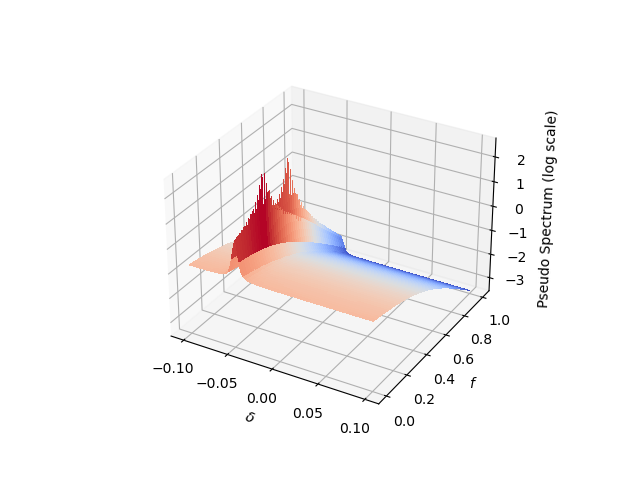

In [51]:
P_z, delta_grid, f_grid = MUSIC(x, n, K)

In [53]:
imax = np.unravel_index(np.argmax(P_z), shape=P_z.shape)
delta_max = delta_grid[imax]
f_max = f_grid[imax]
print(f"delta_max={delta_max}, f_max={f_max}")


delta_max=-0.0466933867735471, f_max=0.24849699398797592


Les pics ne sont malheureusement pas aux bons endroits. Malgré un debbuging conséquent et un ESPRIT qui fonctionne, nous n'avons pas réussi à faire fonctionner MUSIC.

(-0.075, -0.025)

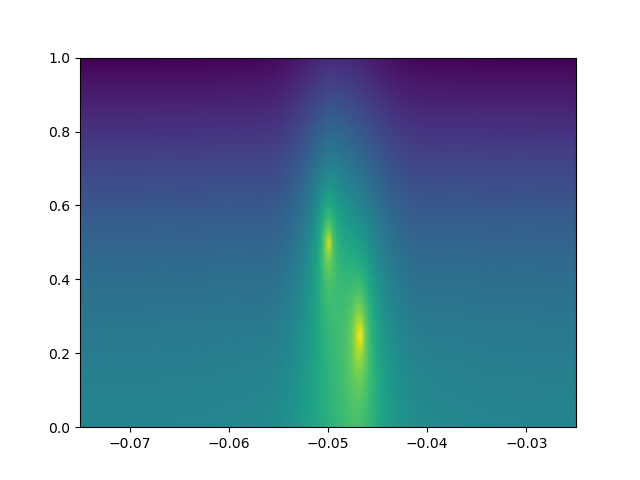

In [54]:
plt.figure()
plt.pcolormesh(delta_grid, f_grid, np.log(P_z), shading="gouraud")
plt.xlim(-.075, -.025)
# plt.ylim()

# Open audio file

In [129]:
wavefile = load_sound('clocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [130]:
play = True
if play :
    play_sound('clocheB.WAV')

In [131]:
T, data, nframes, nchannels, sampling_frequency = read_values('clocheB.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

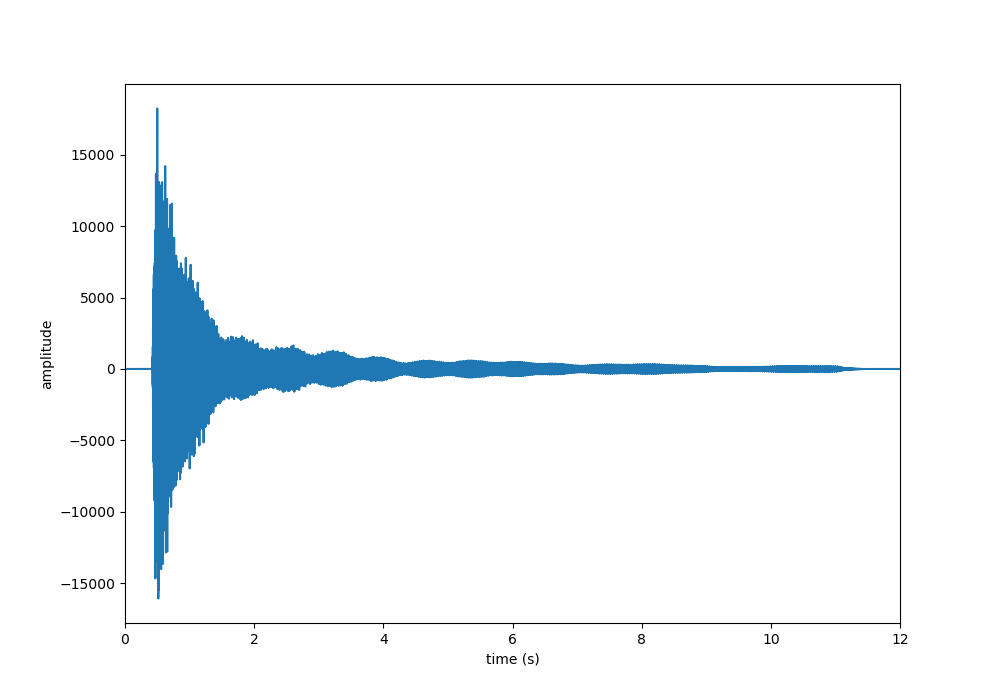

In [132]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [160]:
Nfft = len_x
X = fft(x[0], Nfft)
f = np.linspace(0, 1*Fs, Nfft, endpoint=False)
f_step = Fs/Nfft
# peaks = find_peaks(np.abs(X), height=4e4, distance=int(10//f_step))
peaks = find_peaks(np.abs(X), height=3e5, distance=int(20//f_step))

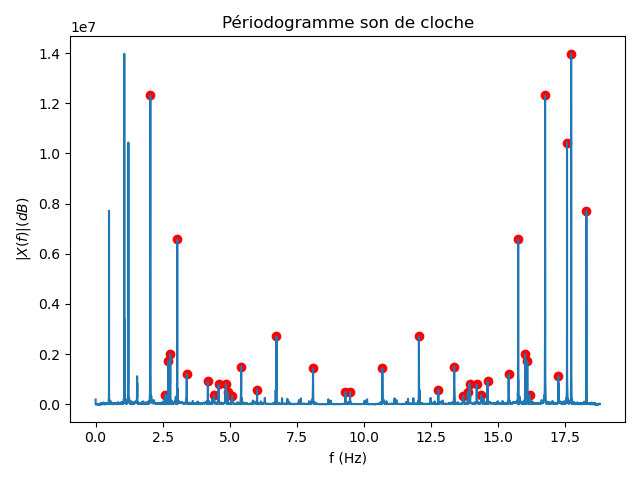

In [161]:
plt.figure()
plt.title('Périodogramme son de cloche')
# plt.plot(f, 20*np.log(np.abs(X)))
plt.plot(f/(2*f[peaks[0][0]]), (np.abs(X)))
plt.scatter(f[peaks[0][4:]]/(2*f[peaks[0][0]]), (np.abs(X))[peaks[0][4:]], c='r')
plt.xlabel('f (Hz)')
plt.ylabel('$|X(f)|$')
plt.tight_layout()

In [169]:
f_peaks_mesured = f[peaks[0][:15]]/(2*f[peaks[0][0]])
# f_peaks_mesured = f[peaks[0][:15]]/(f[peaks[0][1]])
f_expected = np.array([0.5, 1, 1.2, 1.5, 2, 2.5, 2.6, 2.7,
                       3, 3.3, 3.7, 4.2, 4.5, 5, 5.9])
print("Facteurs $ mesurées des pics (relatives par rapport au fondamental) : ", np.round(f_peaks_mesured[:], 2))
print("Fréquences attendues des pics (relatives par rapport au fondamental) : ",
      f_expected[:])
print("Ratio fréquences des pics mesurées sur fréquences des pics attendues :",
      np.round(f_peaks_mesured[:]/f_expected[:],2))

Facteurs $ mesurées des pics (relatives par rapport au fondamental) :  [0.5  1.07 1.22 1.55 2.04 2.6  2.7  2.79 3.04 3.4  4.19 4.42 4.59 4.86
 4.92]
Fréquences attendues des pics (relatives par rapport au fondamental) :  [0.5 1.  1.2 1.5 2.  2.5 2.6 2.7 3.  3.3 3.7 4.2 4.5 5.  5.9]
Ratio fréquences des pics mesurées sur fréquences des pics attendues : [1.   1.07 1.02 1.03 1.02 1.04 1.04 1.03 1.01 1.03 1.13 1.05 1.02 0.97
 0.83]


Les pics mesurés correspondent environ à ceux attendus. Une partie de l'erreur provient d'un faible pic non détecté à un ratio de 3.7

Text(0.5, 1.0, 'Comparaison entre $\\hat{x}_{\\mathrm{ESPRIT}}$ et $x$')

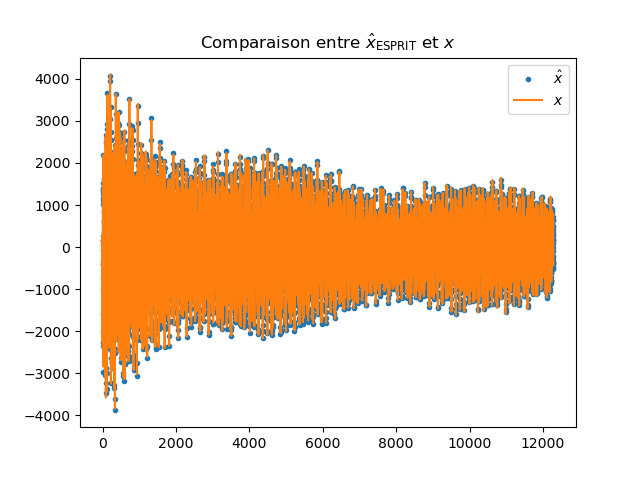

In [186]:
K = 54
n = 512 # * 8
l = 2*n
N = n + l - 1
start_sample = 10000
x_analyse = x[0][start_sample:start_sample+N]

delta_hat, f_hat = ESPRIT(x_analyse,n,K)
a_hat, phi_hat = LeastSquares(x_analyse, delta_hat, f_hat)
x_hat = Synthesis(N, delta_hat, f_hat, a_hat, phi_hat)

plt.figure()
plt.plot(np.real(x_hat), '.', label='$\hat{x}$')
plt.plot(np.real(x_analyse), label='$x$')
plt.legend()
plt.title('Comparaison entre $\hat{x}_{\mathrm{ESPRIT}}$ et $x$')

In [187]:
write('new_bell_synth.wav', Fs, np.array(np.int16(np.real(x_hat)), dtype=np.int16)) # to write a new wave file

L'affichage nous semble confirmer que la reconstruction est très fidèle.
Cependant, à l'oreille, le signal synthétisé ne sonne pas parfaitement similaire au signal d'origine. On reconnait le timbre, mais avec un son moins variant dans le temps, en particulier lorsque l'on teste avec une valeur plus grande de $n$ que celle préconisée dans l'énoncé.

Avec $n=512$ comme proposé initialement, le signal resynthétisé correspond bien à l'attaque d'une cloche, mais cela étant très court, il est difficile de mesurer la différence au signal d'origine.

In [188]:
play_sound('new_bell_synth.wav')